# Introduction

Name | Abid Ilmun Fisabil

Batch | FTDS-006

Phase | 1

## Data Description

**This data frame contains the following columns:**

1. Gender : Male / Female
2. Height : Number (cm)
3. Weight : Number (Kg)
4. Index :
    - 0 - Extremely Weak
    - 1 - Weak
    - 2 - Normal
    - 3 - Overweight
    - 4 - Obesity
    - 5 - Extreme Obesity

## Objective:

Understand the Dataset & cleanup (if required).<br>
Build classification models to predict the various categories of BMI.<br>
Compare the evaluation metrics of various classification algorithms.<br>


# Importing Packages

In [124]:
!pip install pycaret

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report as cr
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer as mct
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.model_selection import GridSearchCV
import random
import pickle

from IPython.display import clear_output

clear_output()

# Loading Data

In [125]:
df = pd.read_csv('../input/bmidataset/bmi.csv')

# Attribute Exploration

In [126]:
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [128]:
df.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [145]:
df = df.drop_duplicates()

data has 500 observations with 4 dimensions

no missing values detected within the data

11 duplicates detected within the data

# EDA

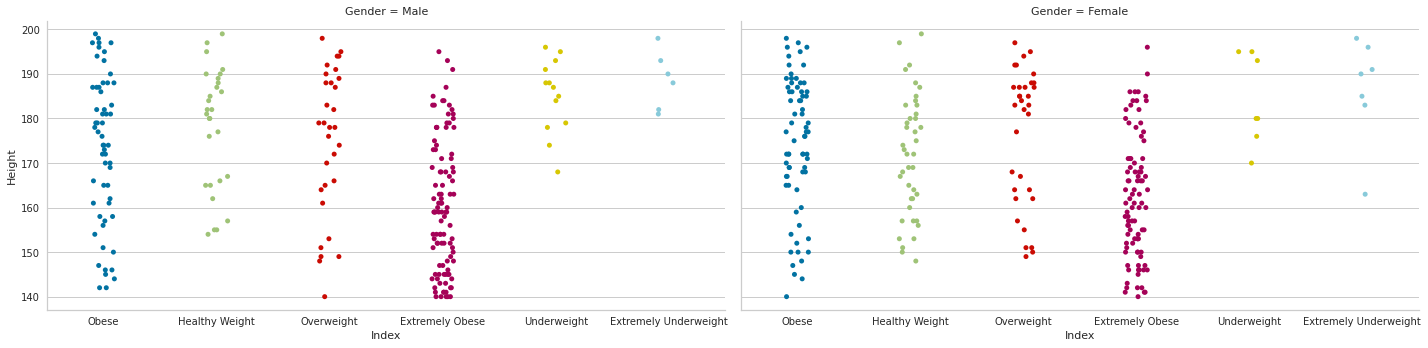

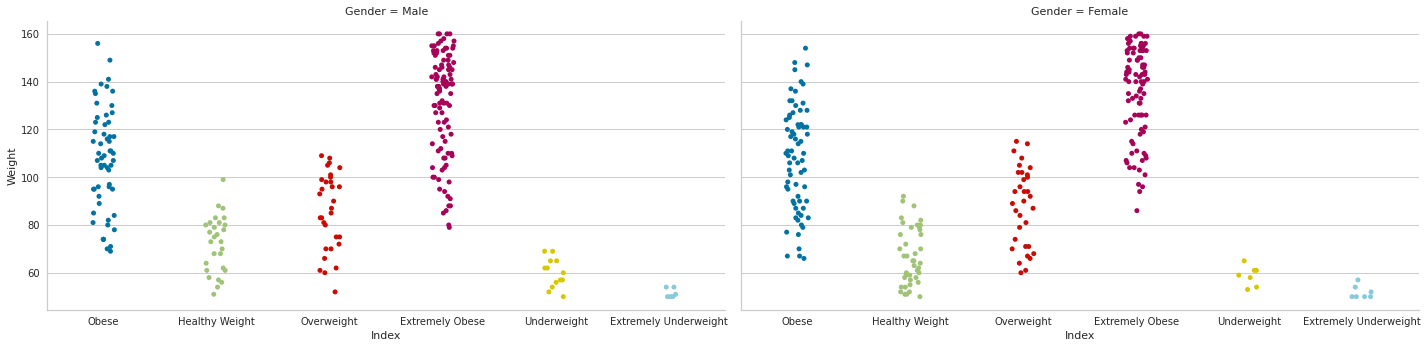

In [130]:
dff = df.copy()
bmi_category = ['Extremely Underweight','Underweight','Healthy Weight','Overweight','Obese','Extremely Obese']
dff.Index = [bmi_category[i] for i in dff.Index] 
sns.catplot(data = dff,x = 'Index',y = 'Height',col = 'Gender', height = 5, aspect =2 );
sns.catplot(data = dff,x = 'Index',y = 'Weight',col = 'Gender', height = 5, aspect =2 );


overall, male and female distribution towards BMI classes seem to be similar. meaning that gender does not correlate to BMI

when the data present underweight and below classes. it only contains tall people with height 170cm and above. meaning that underweight and severly underweight people are almost all very tall

short people (less or equal 150cm) are either overweigth, obese, or extremely obese. 

people with weight greater or equal to 100kg tend to experience obesity or even extreme obesity. 

people with weight less or equal to 80kg tend to be underweight or even extremely underweight. but most of them have healthy weight and only some that are overweight



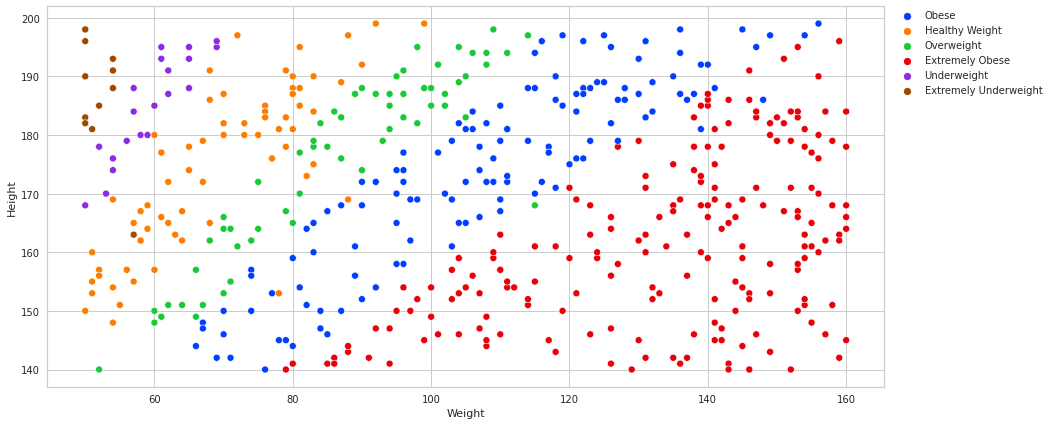

In [131]:
plt.figure(figsize = (15,7))
sns.scatterplot(data = dff,x = 'Weight',y = 'Height', hue = 'Index',palette = 'bright')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

BMI classes seem to be clustered really well. meaning that the machine learning model will not have hard time classifying the features.

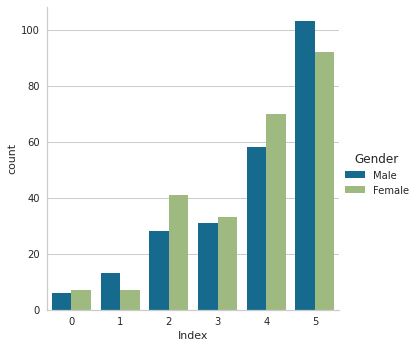

In [132]:
sns.catplot(data = df, x = 'Index',hue = 'Gender',kind = 'count')

our data contains a lot of extreme obesity case. which means our model probably will have more success in predicting extreme obesity. 

the thing is that the data is pretty imbalanced. each BMI classes are not walking shoulder to shoulder

# Selecting Model Candidates

In [133]:
clf1 = setup(data = df, target = 'Index', use_gpu = True)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.8945,0.9890,0.8712,0.8977,0.8923,0.8558,0.8574,0.0130
knn,K Neighbors Classifier,0.8803,0.9745,0.8415,0.8837,0.8758,0.8351,0.8376,0.3160
catboost,CatBoost Classifier,0.8540,0.9771,0.8082,0.8572,0.8500,0.8001,0.8027,1.2820
xgboost,Extreme Gradient Boosting,0.8394,0.9682,0.8046,0.8475,0.8360,0.7800,0.7832,0.4380
lda,Linear Discriminant Analysis,0.8392,0.9830,0.7273,0.8525,0.8282,0.7803,0.7880,0.0120
et,Extra Trees Classifier,0.8219,0.9653,0.7876,0.8334,0.8167,0.7555,0.7601,1.1540
lightgbm,Light Gradient Boosting Machine,0.8218,0.9700,0.7905,0.8313,0.8175,0.7558,0.7605,0.7390
gbc,Gradient Boosting Classifier,0.8072,0.9644,0.7583,0.8185,0.8023,0.7359,0.7409,0.5350
dt,Decision Tree Classifier,0.8011,0.8701,0.7770,0.8117,0.7974,0.7282,0.7325,0.0130
rf,Random Forest Classifier,0.7837,0.9578,0.6590,0.7618,0.7629,0.6983,0.7046,0.6150


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


# Building Model 

In [134]:
model = create_model('qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9143,0.9752,0.7583,0.8876,0.9005,0.8819,0.8830
1,0.9429,0.9991,0.9481,0.9581,0.9449,0.9231,0.9251
2,0.8824,0.9937,0.8796,0.8836,0.8811,0.8381,0.8391
3,0.7647,0.9675,0.7808,0.7605,0.7549,0.6739,0.6771
4,0.9412,0.9971,0.9375,0.9454,0.9413,0.9194,0.9205
5,0.9706,0.9977,0.9881,0.9739,0.9709,0.9599,0.9611
6,0.8529,0.9788,0.7792,0.8595,0.8483,0.7983,0.8003
7,0.9118,0.9958,0.9042,0.9216,0.9131,0.8804,0.8815
8,0.9118,0.9969,0.9256,0.9183,0.9138,0.8808,0.8819
9,0.8529,0.9887,0.8103,0.8686,0.8538,0.8026,0.8044


# Evaluating Model

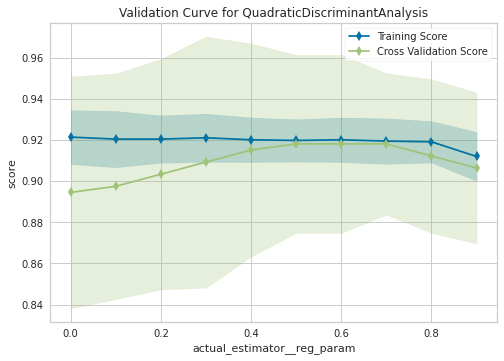

In [135]:
plot_model(model, plot = 'vc')

cross validation and training scores are quite close to each other. it will make quite a gap when the reg_param is somewhere between 0 to 0.2. 

even so, the scores will still be between 91 to 94% 

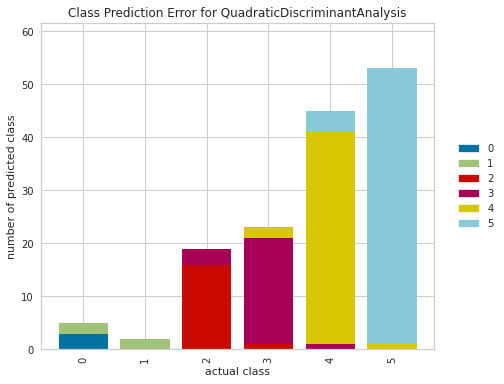

In [136]:
plot_model(model, plot = 'error')

when qda (Quadratic Discriminant Analysis) make predictions over class 1,2, and 5, it's very highly unlikely that it's incorrect. but when it makes prediction over class 0, 3, and 4, theres slight chance that it's going to be wrong

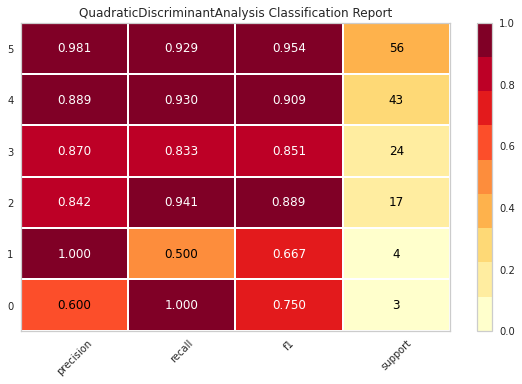

In [137]:
plot_model(model, plot = 'class_report')

when predicting class 5,2,and 1, 100% of the time it will actually be correct

when predicting class 4 92% of the time it will actually be 4

when predicting class 3 78% of the time it will actually be 3. however it will cover 100% actual class 3

when predicting class 0 75% of the time it will actually be 0. even so it will cover 100% actual class 0


## Feature Engineering

In [138]:
model = QuadraticDiscriminantAnalysis()
x = df[df.columns[:-1]]
y = df[df.columns[-1]]
xtrain,xtest,ytrain,ytest = tts(x,y, test_size = .2,stratify = y,random_state = 42)
ct = mct((OneHotEncoder(drop = 'if_binary'),['Gender']),remainder = 'passthrough')
pipe = Pipeline([('ct',ct),
                ('model',model)])
pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(cr(ytest,ypred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4
           2       0.78      1.00      0.88        14
           3       1.00      0.69      0.82        13
           4       0.93      1.00      0.96        26
           5       1.00      0.95      0.97        39

    accuracy                           0.93        98
   macro avg       0.90      0.90      0.88        98
weighted avg       0.94      0.93      0.93        98



In [139]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]
xtrain,xtest,ytrain,ytest = tts(x,y, test_size = .2,stratify = y,random_state = 42)
ct = mct((OneHotEncoder(drop = 'if_binary'),['Gender']),
         (PowerTransformer('yeo-johnson'),['Height','Weight']),
         (StandardScaler(),['Height','Weight']),
         remainder = 'passthrough')
pipe = Pipeline([('ct',ct),
                ('model',model)])
pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(cr(ytest,ypred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4
           2       0.88      1.00      0.93        14
           3       1.00      0.85      0.92        13
           4       0.96      0.96      0.96        26
           5       0.97      0.97      0.97        39

    accuracy                           0.95        98
   macro avg       0.91      0.92      0.91        98
weighted avg       0.95      0.95      0.95        98



the difference engineered feature made was decrease in BMI class 1 recall from 75% to 50%. and left the rest of the classes unchanged. therefore initial model was better

In [140]:
reg_param = [random.uniform(0,1) for i in range(1000)]
grid = {'model__reg_param':reg_param}
clf = GridSearchCV(pipe, grid, cv = 5)
clf.fit(x,y)
clear_output()

In [141]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__reg_param,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015073,0.001566,0.005751,0.000410,0.545592,{'model__reg_param': 0.545592018977909},0.775510,0.785714,0.744898,0.795918,0.845361,0.789480,0.032745,531
1,0.013027,0.001759,0.005438,0.000241,0.36758,{'model__reg_param': 0.36758023833668807},0.836735,0.846939,0.806122,0.816327,0.886598,0.838544,0.028027,370
2,0.011953,0.000491,0.005024,0.000083,0.822382,{'model__reg_param': 0.8223823643206397},0.724490,0.755102,0.642857,0.683673,0.762887,0.713802,0.045100,796
3,0.012127,0.000754,0.005021,0.000075,0.830416,{'model__reg_param': 0.8304158726295164},0.714286,0.755102,0.642857,0.673469,0.762887,0.709720,0.046242,812
4,0.012507,0.000648,0.005131,0.000015,0.116044,{'model__reg_param': 0.11604444054638297},0.897959,0.857143,0.897959,0.857143,0.896907,0.881422,0.019828,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.014106,0.000920,0.005681,0.000125,0.21615,{'model__reg_param': 0.21614965572702005},0.887755,0.867347,0.867347,0.857143,0.907216,0.877362,0.017937,124
996,0.014530,0.000710,0.005770,0.000149,0.167506,{'model__reg_param': 0.1675062045856741},0.877551,0.867347,0.877551,0.857143,0.896907,0.875300,0.013190,193
997,0.013906,0.000632,0.005621,0.000248,0.434991,{'model__reg_param': 0.43499104447879955},0.826531,0.816327,0.785714,0.816327,0.865979,0.822175,0.025829,432
998,0.013215,0.000664,0.005369,0.000038,0.713346,{'model__reg_param': 0.7133457894894497},0.734694,0.755102,0.673469,0.724490,0.804124,0.738376,0.042478,691


In [142]:
model = QuadraticDiscriminantAnalysis(reg_param = clf.best_params_['model__reg_param'])
x = df[df.columns[:-1]]
y = df[df.columns[-1]]
xtrain,xtest,ytrain,ytest = tts(x,y, test_size = .2,stratify = y,random_state = 42)
ct = mct((OneHotEncoder(drop = 'if_binary'),['Gender']),
         (PowerTransformer('yeo-johnson'),['Height','Weight']),
         (StandardScaler(),['Height','Weight']),
         remainder = 'passthrough')
pipe = Pipeline([('ct',ct),
                ('model',model)])
pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(cr(ytest,ypred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4
           2       0.78      1.00      0.88        14
           3       1.00      0.69      0.82        13
           4       0.93      1.00      0.96        26
           5       1.00      0.95      0.97        39

    accuracy                           0.93        98
   macro avg       0.90      0.90      0.88        98
weighted avg       0.94      0.93      0.93        98



using GridSearchCV on 1000 reg_param value candidates only decreased BMI class 4 prediction performance from around 90 to 80% and the rest remained unchanged. hence initial model was better

# Model Inference

In [143]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]
model = QuadraticDiscriminantAnalysis()
ct = mct((OneHotEncoder(drop = 'if_binary'),['Gender']),remainder = 'passthrough')
pipe = Pipeline([('ct',ct),
                ('model',model)])
pipe.fit(xtrain,ytrain)
obs = xtrain.sample(1,random_state = 23)
bmi_category[pipe.predict(obs)[0]]

'Extremely Obese'

# Model Finalization

In [144]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]
model = QuadraticDiscriminantAnalysis()
ct = mct((OneHotEncoder(drop = 'if_binary'),['Gender']),remainder = 'passthrough')
pipe = Pipeline([('ct',ct),
                ('model',model)])
pipe.fit(x,y)
with open('model.pkl','wb') as filename:
    pickle.dump(pipe,filename)